In [74]:
# import libraries 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import CLARA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import skfuzzy as fuzz
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [75]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#c91e29', '#c33b43', 
               '#9DBF9E', '#cd5a61', '#343934', '#e8da6f','#64a0e0', '#913d27', 
               '#F46036', '#5386E4',  '#bea602', '#0a6682', '#215463']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [76]:
df_subset = pd.read_csv('df_subset.csv')

In [77]:
pca_df = pd.read_csv('pca_df.csv')
df_wind_scaled = pd.read_csv('df_wind_scaled.csv')

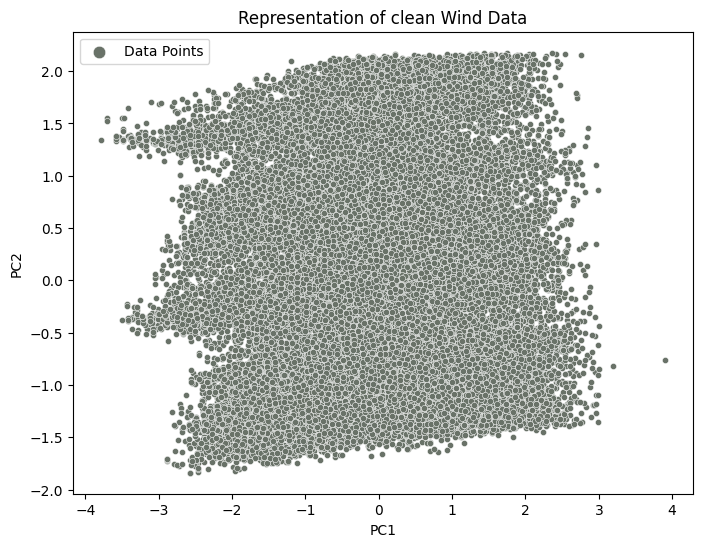

In [78]:
# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', s= 20, color = my_colors[1])
plt.title('Representation of clean Wind Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(labels=['Data Points'], markerscale=2)
plt.show()

# Partition Clustering

## K-Means

### Find the optimal k number by the elbow method

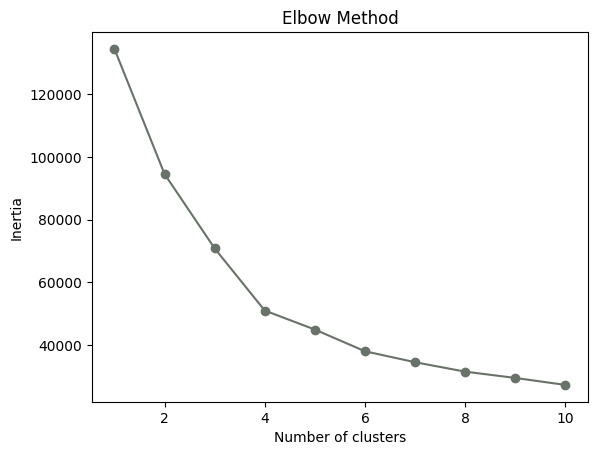

In [79]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df_wind_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,11), inertia, marker = 'o', c = '#697268')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

k = 6, because is where inertia starts decreasing in an almost linear rate

### Clusters

In [80]:
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans.fit(df_wind_scaled)

# Get cluster labels
cluster_labels = kmeans.labels_

In [81]:
with open('results/partitional/kmeans_model.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [82]:
with open('results/partitional/kmeans_model.pickle', 'rb') as f:
    kmeans = pickle.load(f)

In [83]:
cluster_labels = kmeans.labels_

In [84]:
pca_df['cluster'] = cluster_labels
pca_df['asset_id'] = df_subset['asset_id']

In [85]:
df_wind_scaled['cluster'] = cluster_labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

df_wind_scaled.to_csv('results/partitional/csv_labels_raw/kmeans.csv', index=False)

In [86]:
df_wind_scaled = df_wind_scaled.loc[:,:'2']

In [87]:
pca_df['cluster'].nunique()

6

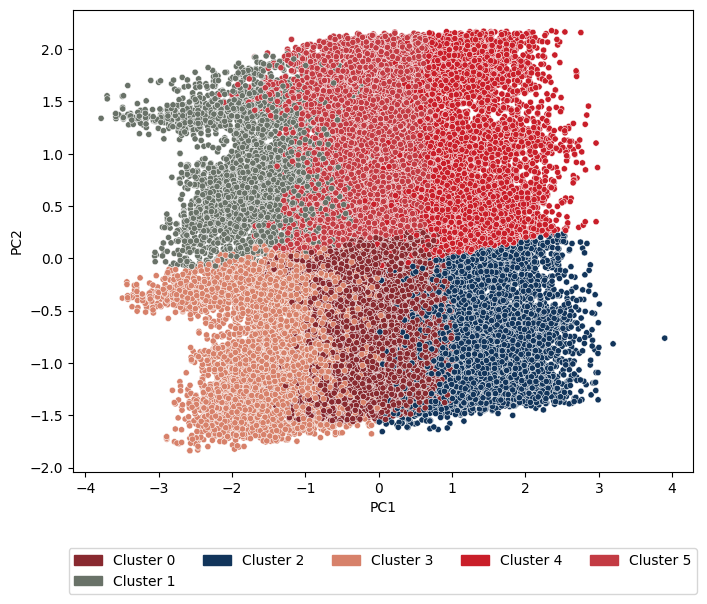

In [88]:
n_clusters = len(pca_df['cluster'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=pallete, s=20)
# plt.title('K-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(cluster_labels)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [89]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster
0,0.738747,-0.734238,11,0
1,-0.199476,0.074563,11,0
2,-0.311128,0.662178,11,0
3,-0.800644,-0.655436,11,0
4,1.737677,1.319443,11,0


In [90]:
pca_df.to_csv('results/partitional/labels_most_common/k_means.csv', index = False)

In [91]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,PC1,PC2,cluster
0,11,0.738747,-0.734238,0
1,12,-1.417553,-1.276716,5
2,13,1.219239,0.026342,0
3,14,-0.177437,0.586863,0
4,15,-0.862632,-1.080627,0


In [92]:
assets_clusters = representative_points.groupby('cluster')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 2, 3, 4, 5, 7, 8, 10, 12, 14, 19, 20, 22, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 49, 50, 51, 52, 54, 56, 61, 62, 64, 65, 68, 70]
Cluster 2: [42, 69]
Cluster 4: [11, 24, 53]
Cluster 5: [1, 6, 9, 13, 15, 16, 17, 18, 21, 23, 25, 26, 33, 47, 48, 55, 57, 58, 59, 60, 63, 66, 67]


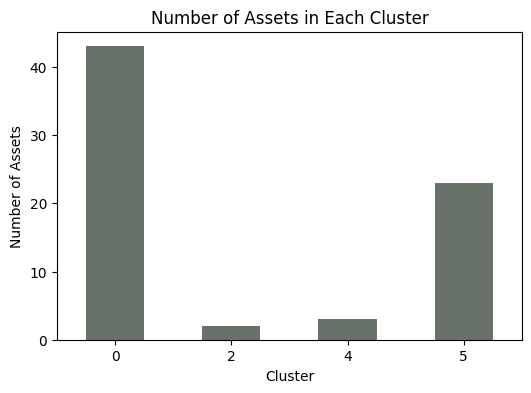

In [93]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [94]:
pca_df = pca_df.loc[:,:'PC2']

df_wind_scaled = df_wind_scaled.loc[:,:'2']

In [95]:
df_wind_scaled

,0,1,2
0,0.797093,-0.426693,0.517135
1,0.035012,-0.925224,-1.204735
2,-0.653319,-0.133978,-0.487289
3,0.600427,0.440781,-0.774268
4,-1.233485,-0.673672,1.952027
...,...,...,...
44796,0.883675,-0.781367,-0.236183
44797,0.090423,0.066471,-0.683870
44798,0.845915,-0.184151,-0.286405
44799,0.770347,1.590069,-0.580557


## K-Medoids (clara)

In [96]:
clara = CLARA(n_clusters=6, random_state=1)
clara.fit(df_wind_scaled)
labels = clara.predict(df_wind_scaled)

In [97]:
pca_df['cluster'] = labels
pca_df['asset_id'] = df_subset['asset_id']

In [98]:
df_wind_scaled['cluster'] = cluster_labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [99]:
df_wind_scaled

,0,1,2,cluster,asset_id
0,0.797093,-0.426693,0.517135,2,11
1,0.035012,-0.925224,-1.204735,0,11
2,-0.653319,-0.133978,-0.487289,5,11
3,0.600427,0.440781,-0.774268,0,11
4,-1.233485,-0.673672,1.952027,4,11
...,...,...,...,...,...
44796,0.883675,-0.781367,-0.236183,0,512
44797,0.090423,0.066471,-0.683870,0,512
44798,0.845915,-0.184151,-0.286405,0,512
44799,0.770347,1.590069,-0.580557,3,512


In [100]:
df_wind_scaled.to_csv('results/partitional/csv_labels_raw/clara.csv', index=False)

In [101]:
df_wind_scaled = df_wind_scaled.loc[:,:'2']

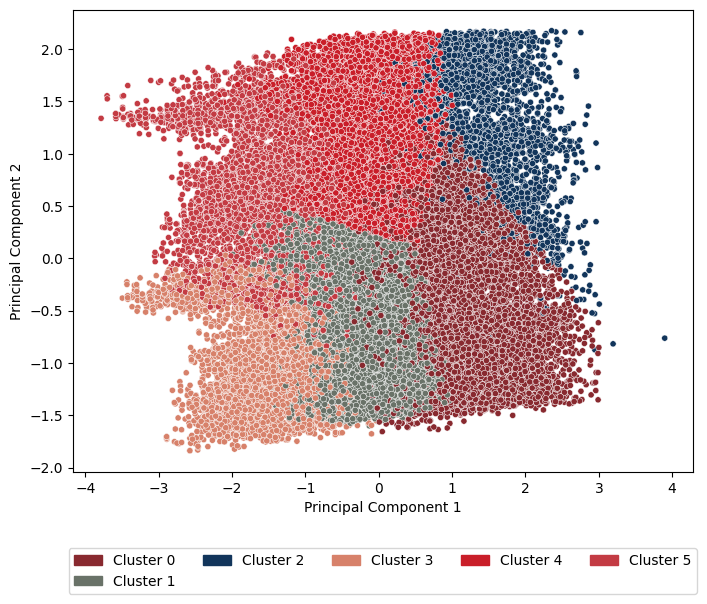

In [102]:
n_clusters = len(pca_df['cluster'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=pallete, s=20)
# plt.title('CLARA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(pca_df['cluster'].unique())],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [103]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster
0,0.738747,-0.734238,11,4
1,-0.199476,0.074563,11,4
2,-0.311128,0.662178,11,4
3,-0.800644,-0.655436,11,4
4,1.737677,1.319443,11,4


In [104]:
pca_df.to_csv('results/partitional/labels_most_common/k_medoids_clara.csv', index=False)

In [105]:
pca_df['asset_id'] = df_subset['asset_id']

In [106]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,PC1,PC2,cluster
0,11,0.738747,-0.734238,4
1,12,-1.417553,-1.276716,4
2,13,1.219239,0.026342,1
3,14,-0.177437,0.586863,1
4,15,-0.862632,-1.080627,1


In [107]:
assets_clusters = representative_points.groupby('cluster')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 36, 39, 41, 42, 53, 54, 55, 56, 59, 60, 61, 69]
Cluster 1: [2, 3, 4, 5, 7, 8, 26, 27, 28, 29, 30, 32, 34, 35, 37, 38, 40, 43, 44, 45, 46, 49, 50, 51, 52, 62, 65, 68, 70]
Cluster 4: [0, 1, 6, 15, 31, 33, 47, 48, 57, 58, 63, 64, 66, 67]


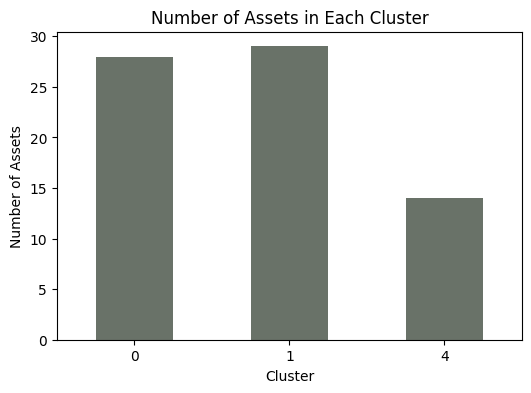

In [108]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [109]:
pca_df = pca_df.loc[:,:'PC2']

In [122]:
df_wind_scaled = df_wind_scaled.loc[:,:'2']

### Fuzzy C-Means

In [123]:
# Define parameters
num_clusters = 6
fuzziness = 2 

# Apply Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    df_wind_scaled.T, num_clusters, fuzziness, error=0.005, maxiter=1000, init=None)

# Extract cluster centroids
cluster_centroids = cntr.T

# Extract cluster membership probabilities
cluster_membership = u.T

# Assign data points to clusters based on membership probabilities
assigned_clusters = np.argmax(cluster_membership, axis=1)

In [124]:
data = {
    "cntr": cntr,
    "u": u,
    "u0": u0,
    "d": d,
    "jm": jm,
    "p": p,
    "fpc": fpc
}

# Open the file in write binary mode
with open('results/partitional/fuzzy_c_means.pickle', "wb") as f:
    # Use pickle to dump the data dictionary into the file
    pickle.dump(data, f)

In [125]:
pca_df['cluster'] = assigned_clusters
pca_df['asset_id'] = df_subset['asset_id']

In [126]:
df_wind_scaled['cluster'] = cluster_labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

df_wind_scaled.to_csv('results/partitional/csv_labels_raw/fuzzy_c_means.csv', index=False)

In [127]:
df_wind_scaled = df_wind_scaled.loc[:,:'2']

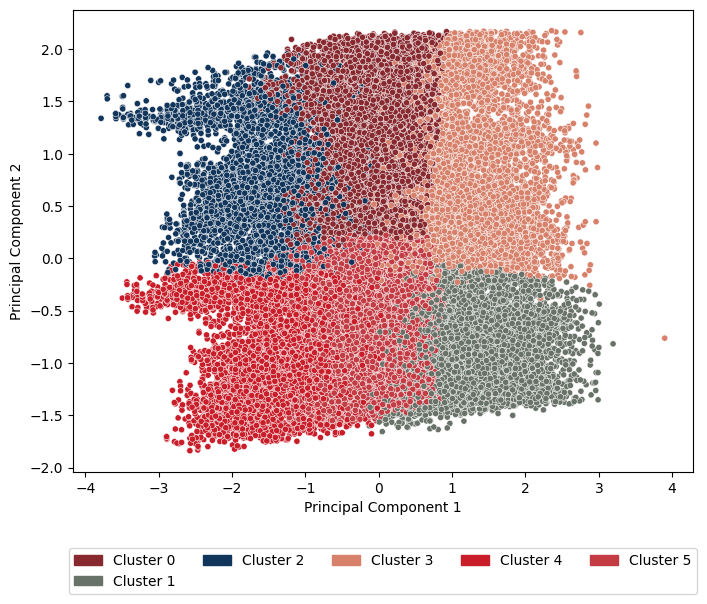

In [128]:
# Plot the representative points on a scatter plot using PCA results

n_clusters = len(pca_df['cluster'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=pallete, s=20)
# plt.title('Fuzzy C-Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(assigned_clusters)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [129]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

In [130]:
pca_df.to_csv('results/partitional/labels_most_common/fuzzy_c_means.csv', index = False)

In [131]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster
0,11,0.738747,-0.734238,0
1,12,-1.417553,-1.276716,0
2,13,1.219239,0.026342,5
3,14,-0.177437,0.586863,0
4,15,-0.862632,-1.080627,5
...,...,...,...,...
66,414,0.264004,1.670331,0
67,415,-0.666128,2.044155,0
68,510,-1.564608,-1.066597,5
69,511,-0.431002,-1.542170,1


In [132]:
assets_clusters = pca_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [11, 12, 14, 17, 21, 25, 26, 27, 28, 29, 31, 32, 34, 37, 38, 39, 45, 47, 112, 113, 114, 115, 311, 312, 313, 314, 315, 316, 411, 414, 415]
Cluster 1: [24, 57, 511]
Cluster 3: [23, 33, 36, 210]
Cluster 5: [13, 15, 16, 18, 19, 22, 35, 41, 42, 43, 44, 46, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 110, 111, 116, 117, 310, 317, 410, 412, 413, 510, 512]


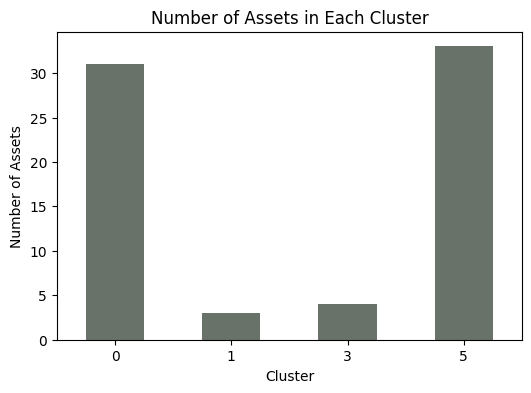

In [133]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()